#**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Loading Pre-Processed Data from Drive**

In [ ]:
import pandas as pd

df_preprocessed = pd.read_csv('/content/drive/MyDrive/Computational Intelligence in Automation/preprocessed_data.csv')
display(df_preprocessed)

,sentiment,text
0,0,that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdbcom cool hear old walt interview â
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


#**Removing NaN Values**

In [ ]:
# Check for NaN values in 'text' column
print("Checking for NaN values in 'text' column:")
print(df_preprocessed['text'].isna().sum())

Checking for NaN values in 'text' column:
7211


In [ ]:
# Handle NaN values (remove rows with NaN in 'text' column)
df_final = df_preprocessed.dropna(subset=['text'])

#**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final['text'], df_final['sentiment'], test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1274231,)
(318558,)
(1274231,)
(318558,)


#**Vectorization of Data (Creating Bag of Words)**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Create Bag-of-Words Representation
vectorizer = CountVectorizer(max_features=10000)  # Limit to top 5000 features
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1274231, 10000)
(318558, 10000)


#**Multinomial Naive Bayes (Non-Private)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Initialize model (Multinomial Naive Bayes in this example)
model = MultinomialNB()

# Training loop without differential privacy
num_epochs = 10  # Example number of epochs

for epoch in range(num_epochs):
    # Train the model on the entire training set in one go (no batches)
    model.fit(X_train_bow, y_train)

# Evaluate your model
y_pred = model.predict(X_test_bow)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7643160743098588


#**Differentially Private Multinomial Naive Bayes**

###**The Laplace Mechanism**

Epsilon: 0.1, Accuracy: 0.705309551164937
Epsilon: 0.5, Accuracy: 0.7596261905210354
Epsilon: 1, Accuracy: 0.7627339448389304
Epsilon: 5, Accuracy: 0.7641559778753005
Epsilon: 10, Accuracy: 0.7643192134556345


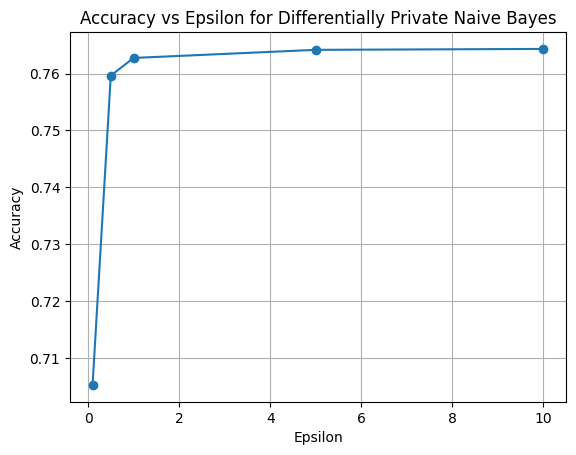

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

# Your data preparation code here
# Assuming X_train_bow, X_test_bow, y_train, y_test are already defined

# Define the values of epsilon to test
epsilon_values = [0.1, 0.5, 1, 5, 10]
accuracies = []

# Define other parameters
num_epochs = 10  # Example number of epochs
batch_size = 32  # Example batch size
sensitivity = 1.0 / batch_size  # Example sensitivity, adjust based on your model

for epsilon in epsilon_values:
    model = MultinomialNB()

    for epoch in range(num_epochs):
        for i in range(0, X_train_bow.shape[0], batch_size):
            # Extract batch
            X_batch = X_train_bow[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Train model on batch
            if i == 0 and epoch == 0:
                # Initialize the model with partial_fit on the first batch
                model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            else:
                model.partial_fit(X_batch, y_batch)

        # After each epoch, add noise to the model parameters (probabilities)
        # Scale for differential privacy
        scale = sensitivity / epsilon

        # Add Laplace noise to the model parameters (probabilities)
        for feature_idx in range(model.feature_count_.shape[1]):
            noise = np.random.laplace(0, scale, 2)  # Generate noise for each class
            model.feature_log_prob_[0, feature_idx] += noise[0]
            model.feature_log_prob_[1, feature_idx] += noise[1]

    # Evaluate your model
    y_pred = model.predict(X_test_bow)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy}")

# Plot the results
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon for Differentially Private Naive Bayes')
plt.grid(True)
plt.show()

###**The Gaussian Mechanism**

Epsilon: 0.1, Accuracy: 0.5952699351452483
Epsilon: 0.5, Accuracy: 0.7312043646682864
Epsilon: 1, Accuracy: 0.7478826461743231
Epsilon: 5, Accuracy: 0.7594347026287207
Epsilon: 10, Accuracy: 0.7600280011803188


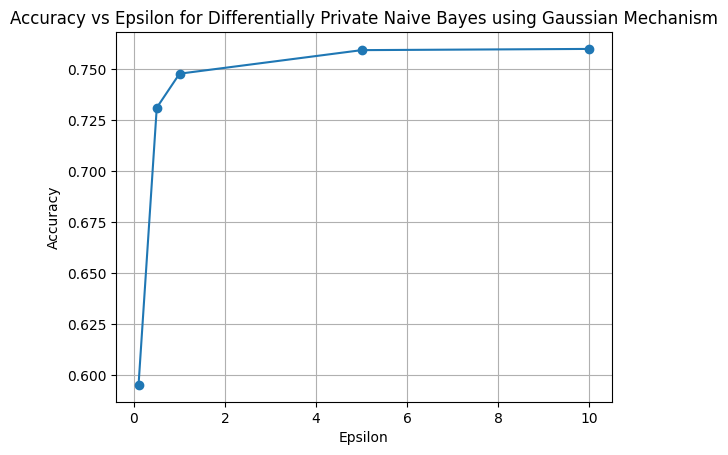

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Create Bag-of-Words Representation
vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Define the values of epsilon to test
epsilon_values = [0.1, 0.5, 1, 5, 10]
accuracies = []

# Define other parameters
num_epochs = 10  # Example number of epochs
batch_size = 32  # Example batch size
sensitivity = 1.0 / batch_size  # Example sensitivity, adjust based on your model
delta = 1e-5  # Small delta for overall privacy budget

def compute_sigma(epsilon, delta, sensitivity):
    # Compute the standard deviation (sigma) of the Gaussian noise
    return np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon

for epsilon in epsilon_values:
    model = MultinomialNB()

    for epoch in range(num_epochs):
        for i in range(0, X_train_bow.shape[0], batch_size):
            # Extract batch
            X_batch = X_train_bow[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Train model on batch
            if i == 0 and epoch == 0:
                # Initialize the model with partial_fit on the first batch
                model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            else:
                model.partial_fit(X_batch, y_batch)

        # After each epoch, add noise to the model parameters (probabilities)
        sigma = compute_sigma(epsilon, delta, sensitivity)

        # Add Gaussian noise to the model parameters (probabilities)
        for feature_idx in range(model.feature_count_.shape[1]):
            noise = np.random.normal(0, sigma, 2)  # Generate noise for each class
            model.feature_log_prob_[0, feature_idx] += noise[0]
            model.feature_log_prob_[1, feature_idx] += noise[1]

    # Evaluate your model
    y_pred = model.predict(X_test_bow)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy}")

# Plot the results
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon for Differentially Private Naive Bayes using Gaussian Mechanism')
plt.grid(True)
plt.show()
